# 第三章示例项目：犬种识别器 Canine Breed Identification App

## 卷积神经网络和迁移学习 Convolutional Neural Networks and Transfer Learning

Ref.: [Udacity Dog Project](https://github.com/udacity/dog-project/)

---

### Why We're Here 

In this notebook, we will develop an algorithm that will accept any user-supplied image as input. If a dog is detected in the image, it will provide an estimate of the dog's breed. The image below displays potential sample output of the finished project. 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, we will need to piece together a series of models to perform different tasks.  There are many points of possible failure, and no perfect algorithm exists. Our imperfect solution will nonetheless create a fun user experience.

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Dogs 图里有没有狗？
* [Step 2](#step2): Create 1st CNN to Classify Dog Breeds from Scratch 从头建卷积神经网络：哪种狗？
* [Step 3](#step3): Use 2nd CNN to Classify Dog Breeds using Transfer Learning 迁移学习（一）：哪种狗？
* [Step 4](#step4): Create 3rd CNN to Classify Dog Breeds using Transfer Learning 迁移学习（二）：哪种狗？
* [Step 5](#step5): Write our Algorithm 组成一个应用程序
* [Step 6](#step6): Test our Algorithm 试一下

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

Sample directory name:  ./dogImages/train/001.Affenpinscher/


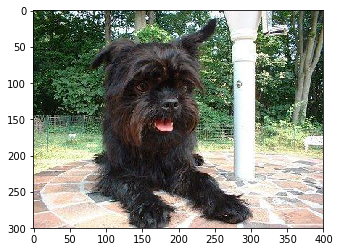


There are 133 total dog categories (one directory for one category).

There are 8351 total dog images:
6680 training
835 validation
836 test


In [2]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob
import os

import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# define function to preview the first image under this directory
def preview_image(directory):
    img_path = directory + os.listdir(directory)[0]
    #print(img_path)
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.show()

# load train, validation and test sets
train_files, train_targets = load_dataset('./dogImages/train')
valid_files, valid_targets = load_dataset('./dogImages/valid')
test_files, test_targets = load_dataset('./dogImages/test')

# load all categories(directories) into a list
sorted_dir_list = sorted(glob("./dogImages/train/*/"))
# preview the first directory name
print('Sample directory name: ', sorted_dir_list[0])
# preview a image from the first category
preview_image(sorted_dir_list[0])
# load list of dog names
dog_names = [item[20:-1] for item in sorted_dir_list]

# print statistics about the dataset
print('\nThere are %d total dog categories (one directory for one category).\n' % len(dog_names))
print('There are %s total dog images:' % len(np.hstack([train_files, valid_files, test_files])))
print('%d training' % len(train_files))
print('%d validation' % len(valid_files))
print('%d test'% len(test_files))

---
<a id='step1'></a>
## Step 1: Detect Dogs 图里有没有狗

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  

Our first line of code **downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/)**, a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](./imagenet_categories.txt).  

**Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet)** for the object that is contained in the image.

利用已经训练好的（残差）神经网络，来探测图片里有没有（是不是）狗。

这个神经网络在ImageNet数据集上训练的，可以分辨1000种对象。

输入图片，输出是每种对象的概率。

### Load ResNet-50 Model 加载模型

In [4]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data 预处理数据

When using TensorFlow as backend, Keras CNNs require a **4D array** (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first **loads the image** and **resizes it to a square image** that is $224 \times 224$ pixels.  Next, the **image is converted to an array**, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in our dataset!

In [5]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path, small=False):
    if small is False:
        # loads RGB image as PIL.Image.Image type
        img = image.load_img(img_path, target_size=(224, 224))
    else:
        img = image.load_img(img_path, target_size=(64, 64))
    # convert PIL.Image.Image type to 3D tensor with shape (rows, cols, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, rows, cols, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths, small=False):
    list_of_tensors = [path_to_tensor(img_path, small) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50 预测

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  
1. First, the RGB image is **converted to BGR** by reordering the channels. 
2. All pre-trained models have the additional **normalization** step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  

This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By **taking the argmax of the predicted probability vector**, we obtain an integer corresponding to the model's predicted object class, which we can **identify with an object category through the use of this [dictionary](./imagenet_categories.txt)**. 

In [6]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path, small=False):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path, small))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector 组成探测器

While looking at the dictionary, we will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to [dictionary](./imagenet_categories.txt) **keys 151-268**, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [7]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path, small=False):
    prediction = ResNet50_predict_labels(img_path, small)
    return ((prediction <= 268) & (prediction >= 151)) 

### Assess the Dog Detector 探测，并评估结果

__Question 3:__ Use the code cell below to test the performance of `dog_detector` function.    
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

In [8]:
### TODO: Test the performance of the dog_detector function
### on the images in dog_files_short.

dog_files_short = train_files[:100]

print("{} % images in dog_files detected dogs".format(
    100 * np.sum([dog_detector(file_path, False) for file_path in dog_files_short]) / len(dog_files_short)))

100.0 % images in dog_files detected dogs


---
<a id='step2'></a>
## Step 2: Create 1st CNN to Classify Dog Breeds from Scratch 
## 从头建一个卷积神经网络来分犬种

Now that we have functions for detecting dogs in images, we need a way to predict breed from images.  In this step, we will create a CNN that classifies dog breeds.  We must create our CNN _from scratch_ (so, we can't use transfer learning _yet_!), and we must **attain a test accuracy of at least 1%**.  In Step 3 of this notebook, we will use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means we are more likely to need a GPU to accelerate the training process.  Thankfully, **Keras provides a handy estimate of the time that each epoch is likely to take**; we can extrapolate this estimate to figure out how long it will take for our algorithm to train. 

We mention that the task of **assigning breed to dogs from images is considered exceptionally challenging**.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that **labradors come in yellow, chocolate, and black**.  Our vision-based algorithm will have to **conquer this high intra-class variation** to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, **a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%**.  

Remember that the practice is far ahead of the theory in deep learning.  **Experiment with many different architectures, and trust our intuition.  And, of course, have fun! **

### Pre-process the Data

We **rescale the images by dividing every pixel in every image by 255**.

In [9]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# To train this CNN on CPU, we use small image size
SMALL = True

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files, SMALL).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files, SMALL).astype('float32')/255
test_tensors = paths_to_tensor(test_files, SMALL).astype('float32')/255

100%|██████████| 836/836 [00:14<00:00, 57.83it/s]


### Model Architecture

Create a CNN to classify dog breed.  At the end of our code cell block, summarize the layers of our model by executing the line:
    
        model.summary()

Here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn_b.png)
           
__Question 4:__ Outline the steps we took to get final CNN architecture and the reasoning at each step.  If chose to use the hinted architecture above, describe why that CNN architecture should work well for the image classification task.

__Answer:__ The hinted CNN architecture should work well, since the 3 convolutional layers would work for feature extraction. Moreover, 2 dropout layers for regularization and one more fully connected layer for better classification have been added.

In [11]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

### TODO: Define architecture.

model.add(Conv2D(filters=16, kernel_size=2, strides=2, activation='relu', input_shape=(64, 64, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, strides=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, strides=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(GlobalAveragePooling2D())
model.add(Dense(133, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 16)        208       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 32)          2080      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 2, 2, 64)          8256      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 1, 1, 64)          0         
_________________________________________________________________
global_average_pooling2d_2 ( (None, 64)                0         
__________

### Compile the Model

In [13]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### Train the Model

Train  model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html).

In [14]:
from keras.callbacks import ModelCheckpoint  

### TODO: specify the number of epochs that we would like to use to train the model.

epochs = 10

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/10
6680/6680 [==============================] - 4s 564us/step - loss: 4.8843 - acc: 0.0091 - val_loss: 4.8713 - val_acc: 0.0120
Epoch 2/10
6680/6680 [==============================] - 3s 395us/step - loss: 4.8661 - acc: 0.0091 - val_loss: 4.8652 - val_acc: 0.0096
Epoch 3/10
6680/6680 [==============================] - 3s 397us/step - loss: 4.8422 - acc: 0.0132 - val_loss: 4.8363 - val_acc: 0.0168
Epoch 4/10
6680/6680 [==============================] - 3s 400us/step - loss: 4.7823 - acc: 0.0208 - val_loss: 4.8203 - val_acc: 0.0192
Epoch 5/10
6680/6680 [==============================] - 3s 401us/step - loss: 4.7154 - acc: 0.0268 - val_loss: 4.7514 - val_acc: 0.0323
Epoch 6/10
6680/6680 [==============================] - 3s 404us/step - loss: 4.6520 - acc: 0.0355 - val_loss: 4.6991 - val_acc: 0.0347
Epoch 7/10
6680/6680 [==============================] - 3s 405us/step - loss: 4.5710 - acc: 0.0437 - val_loss: 4.6586 - val_acc: 0.0359
E

### Load the Model with the Best Validation Loss

In [15]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Try out our model on the test dataset of dog images.  Ensure that our test accuracy is greater than 1%.

In [16]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 4.7847%


---
<a id='step3'></a>
## Step 3: Use 2nd CNN to Classify Dog Breeds Using Transfer Learning
## 使用迁移学习：利用训练好的卷积神经网络来提取特征，从而分犬种

To reduce training time without sacrificing accuracy, we train a CNN using transfer learning. In the following step, we will get a chance to use transfer learning to train our own CNN.

### Obtain Bottleneck Features 瓶颈特征

`Bottleneck Features`: Input data is image, which is is pre-computed through the trained CNN model (feature extractor) and then get the output data. The output data is called as bottleneck features and used as the input for the training of the subsequent classifier. 

特征提取器是已经训练好卷积神经网络，用来提取图片种的特征。也就是说，输入图片，预先计算好并输出（提取好的特征：瓶颈特征），作为后面分类器的输入数据。

In [17]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

`Transfer Learning`: Use trained networks 脑袋, e.g. feature extractor, to get better features and save training effort, since no need to train again such part. 借用已经训练好的外脑来提取特征（特征提取器），不但提升质量、而且节省训练时间。On basis of such trained feature extrator, add classifier, e.g. fully connected and softmax layers. 在此基础上，增加全连接层和归一化指数层，也就是分类器。

![Transfer_Learning](images/TransferLearning05_b.png)

In [18]:
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Dense

VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_3 ( (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [19]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [20]:
from keras.callbacks import ModelCheckpoint 

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 2s 297us/step - loss: 11.9755 - acc: 0.1302 - val_loss: 10.5057 - val_acc: 0.2275
Epoch 2/20
6680/6680 [==============================] - 1s 158us/step - loss: 9.7993 - acc: 0.3036 - val_loss: 9.7448 - val_acc: 0.3114
Epoch 3/20
6680/6680 [==============================] - 1s 158us/step - loss: 9.3001 - acc: 0.3626 - val_loss: 9.7262 - val_acc: 0.3269
Epoch 4/20
6680/6680 [==============================] - 1s 159us/step - loss: 9.1243 - acc: 0.3886 - val_loss: 9.4552 - val_acc: 0.3437
Epoch 5/20
6680/6680 [==============================] - 1s 160us/step - loss: 8.9819 - acc: 0.4115 - val_loss: 9.4494 - val_acc: 0.3473
Epoch 6/20
6680/6680 [==============================] - 1s 160us/step - loss: 8.9199 - acc: 0.4260 - val_loss: 9.3769 - val_acc: 0.3569
Epoch 7/20
6680/6680 [==============================] - 1s 161us/step - loss: 8.8321 - acc: 0.4305 - val_loss: 9.2924 - val_acc: 0.3605

### Load the Model with the Best Validation Loss

In [21]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [22]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 45.4545%


### Predict Dog Breed with the Model

In [21]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step4'></a>
## Step 4: Use 3rd CNN to Classify Dog Breeds Using Transfer Learning
## 迁移学习：再使用另外一个训练好的卷积神经网络特征提取器，来分犬种

We now use transfer learning to create a CNN that can identify dog breed from images. Our CNN must attain at least 60% accuracy on the test set.

In Step 3, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, we will use the bottleneck features from a different pre-trained model.  To make things easier, we have pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [23]:
### TODO: Obtain bottleneck features from another pre-trained CNN.
bottleneck_features = np.load('bottleneck_features/DogResnet50Data.npz')
train_Resnet50 = bottleneck_features['train']
valid_Resnet50 = bottleneck_features['valid']
test_Resnet50 = bottleneck_features['test']

### Model Architecture

Create a CNN to classify dog breed.  At the end of this code cell block, summarize the layers of our model by executing the line:
    
        <our model's name>.summary()
   
__Question 5:__ Outline the steps we took to get to our final CNN architecture and our reasoning at each step.  Describe why we think the architecture is suitable for the current problem.

__Answer:__ First, ResNet50 was selected for transfer learning since its architecture has very good feature extraction performance. Then, as done in the above cell, bottleneck features were obtained and will be the inputs for training  output classifier. Global Average Pooling was applied on the input to reduce dimensionality, and dropout was then done for regularization. For breed classification, two, rather than one as in Step 3, fully connected layers were used with relu and softmax activation respectively.

Such architecture takes advantage of the good feature extraction capabability of ResNet50 from transfer learning. Also by adding one more fully connected layer, its classification capabability will be improved significantly. 

In [24]:
### TODO: Define architecture.

from keras.layers import GlobalAveragePooling2D, Dropout, Dense
from keras.models import Sequential

Resnet50_model = Sequential()
Resnet50_model.add(GlobalAveragePooling2D(input_shape=train_Resnet50.shape[1:]))
Resnet50_model.add(Dropout(0.3))
Resnet50_model.add(Dense(256, activation='relu'))
Resnet50_model.add(Dropout(0.3))
Resnet50_model.add(Dense(133, activation='softmax'))

Resnet50_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_4 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               524544    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 133)               34181     
Total params: 558,725
Trainable params: 558,725
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [25]:
### TODO: Compile the model.
Resnet50_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

Train our model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [26]:
### TODO: Train the model.
from keras.callbacks import ModelCheckpoint 

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Resnet50.hdf5', 
                               verbose=1, save_best_only=True)

Resnet50_model.fit(train_Resnet50, train_targets, 
          validation_data=(valid_Resnet50, valid_targets),
          epochs=10, batch_size=20, callbacks=[checkpointer], verbose=1)


Train on 6680 samples, validate on 835 samples
Epoch 1/10
6680/6680 [==============================] - 3s 406us/step - loss: 2.6751 - acc: 0.3726 - val_loss: 0.9966 - val_acc: 0.6910
Epoch 2/10
6680/6680 [==============================] - 2s 251us/step - loss: 1.1324 - acc: 0.6626 - val_loss: 0.7679 - val_acc: 0.7581
Epoch 3/10
6680/6680 [==============================] - 2s 250us/step - loss: 0.8319 - acc: 0.7431 - val_loss: 0.6567 - val_acc: 0.7928
Epoch 4/10
6680/6680 [==============================] - 2s 248us/step - loss: 0.6733 - acc: 0.7867 - val_loss: 0.6998 - val_acc: 0.7725
Epoch 5/10
6680/6680 [==============================] - 2s 248us/step - loss: 0.5720 - acc: 0.8205 - val_loss: 0.7061 - val_acc: 0.7988
Epoch 6/10
6680/6680 [==============================] - 2s 254us/step - loss: 0.5298 - acc: 0.8383 - val_loss: 0.7453 - val_acc: 0.8036
Epoch 7/10
6680/6680 [==============================] - 2s 252us/step - loss: 0.4831 - acc: 0.8484 - val_loss: 0.6581 - val_acc: 0.8251
E

### Load the Model with the Best Validation Loss

In [27]:
### TODO: Load the model weights with the best validation loss.
Resnet50_model.load_weights('saved_models/weights.best.Resnet50.hdf5')

### Test the Model

Try out our model on the test dataset of dog images. Ensure that our test accuracy is greater than 60%.

In [28]:
### TODO: Calculate classification accuracy on the test dataset.
# get index of predicted dog breed for each image in test set
Resnet50_predictions = [np.argmax(Resnet50_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Resnet50]

# report test accuracy
test_accuracy = 100*np.sum(np.array(Resnet50_predictions)==np.argmax(test_targets, axis=1))/len(Resnet50_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 77.6316%


### Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by our model.  

Similar to the analogous function in Step 4, our function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to our chosen CNN architecture, we need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [29]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

from extract_bottleneck_features import *

def Resnet50_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = Resnet50_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Write our Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a dog. Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if __no dog__ is detected in the image, provide output that indicates an error.

Write our own functions for detecting humans and dogs in images, but feel free to use the `dog_detector` functions developed above.  We are __required__ to use our CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design our own user experience!

![Sample Human Output](images/DogProject03.png)


### Write our Algorithm

In [30]:
### TODO: Write algorithm.
### Feel free to use as many code cells as needed.

import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline

def breed_finder(img_path):
    if dog_detector(img_path):
        identity = 'puppy'
        breed = Resnet50_predict_breed(img_path).split('.')[1]
    else:
        identity = 'unknown'
        breed = 'error'

    print('Hello, {}!'.format(identity))
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.show()
    print('You look like a ...\n{}'.format(breed))

---
<a id='step6'></a>
## Step 6: Test our Algorithm

In this section, take new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### Test Algorithm on Sample Images!

Test algorithm at least six images on your computer.  Feel free to use any images you like.

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ The output is better than my expectation. Possible improvements can include:
* augment training images
* add one more fully connected layers or try different layer sizes
* fine tune hyper-parameters, e.g. learning rate, for the output layers

Hello, unknown!


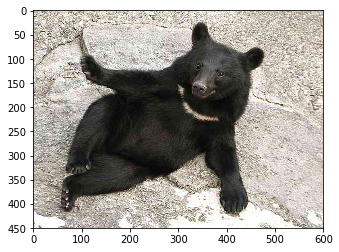

You look like a ...
error

Hello, puppy!


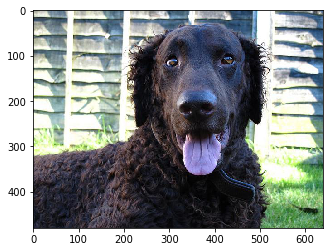

You look like a ...
Curly-coated_retriever

Hello, puppy!


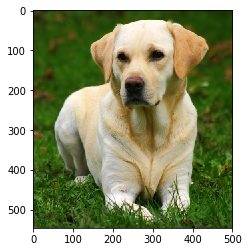

You look like a ...
Labrador_retriever

Hello, unknown!


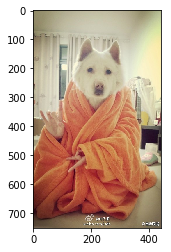

You look like a ...
error

Hello, unknown!


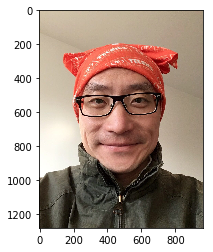

You look like a ...
error

Hello, unknown!


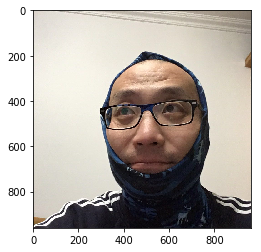

You look like a ...
error

Hello, unknown!


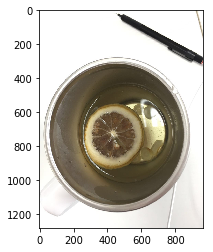

You look like a ...
error



In [31]:
## TODO: Execute our algorithm from Step 5 on at least 6 images.
## Feel free to use as many code cells as needed.

import glob
test_img_dir = "test_images/"
for img_path in glob.glob(test_img_dir+"*.png") + glob.glob(test_img_dir+"*.jpg"):
    breed_finder(img_path)
    print()